In [1]:
import pandas as pd

In [2]:
# Center for Food Safety and Applied Nutrition Adverse Event Reporting System (CAERS) report
df = pd.read_csv ("D:\\Data analytics\\Python Projects\\CAERS-Quarterly-20240731-CSV-PRODUCT-BASED.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221177 entries, 0 to 221176
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   DATE_FDA_FIRST_RECEIVED_REPORT  221177 non-null  object 
 1   REPORT_ID                       221177 non-null  object 
 2   DATE_EVENT                      152657 non-null  object 
 3   PRODUCT_TYPE                    221177 non-null  object 
 4   PRODUCT                         221176 non-null  object 
 5   PRODUCT_CODE                    221177 non-null  object 
 6   DESCRIPTION                     221177 non-null  object 
 7   PATIENT_AGE                     148700 non-null  float64
 8   AGE_UNITS                       148700 non-null  object 
 9   SEX                             210811 non-null  object 
 10  CASE_MEDDRA_PREFERRED_TERMS     221177 non-null  object 
 11  CASE_OUTCOME                    221177 non-null  object 
dtypes: float64(1), o

In [4]:
df.sample(5)


,DATE_FDA_FIRST_RECEIVED_REPORT,REPORT_ID,DATE_EVENT,PRODUCT_TYPE,PRODUCT,PRODUCT_CODE,DESCRIPTION,PATIENT_AGE,AGE_UNITS,SEX,CASE_MEDDRA_PREFERRED_TERMS,CASE_OUTCOME
143809,5/18/2016,196382,4/26/2016,SUSPECT,WHOLE BLUE POPPY SEEDS,28,"Spices, Flavors And Salts",2.0,year(s),Male,"ABNORMAL BEHAVIOUR, EXCORIATION, PRURITUS, PRU...",Other Serious or Important Medical Event
45429,9/9/2021,2022-CFS-000035,1/1/2009,SUSPECT,EXEMPTION 4,53,Cosmetics,4.0,decade(s),Female,Ovarian cancer,Other Serious or Important Medical Event
198965,12/30/2009,121985,12/4/2009,SUSPECT,SOLGAR CALCIUM MAGNESIUM PLUS VITAMIN D,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,Female,"CHOKING, FOREIGN BODY TRAUMA, PHARYNGITIS","Required Intervention, Visited Emergency Room"
66508,9/25/2020,2020-CFS-009326,10/28/2014,SUSPECT,EXEMPTION 4,53,Cosmetics,61.0,year(s),Female,Ovarian cancer,"Hospitalization, Other Serious or Important Me..."
104072,3/15/2018,2018-CFS-004598,2/17/2018,SUSPECT,METAGENICS ESTROVERA,54,Vit/Min/Prot/Unconv Diet(Human/Animal),66.0,year(s),Female,"Arthralgia, Asthenia, Gait disturbance, Inflam...",Other Serious Outcome


# Finding what needs to be fixed in data #
---
### 1. Data Cleaning and Standardization Tasks ###
##### a. Data type corrections needed: #####
- [DATE_FDA_FIRST_RECEIVED_REPORT]: object --> datetime
- [DATE_EVENT]: object --> datetime
##### b. Format corrections needed: #####
- Correct the inconsistent format in [REPORT_ID]
##### c. Unit Standardization: #####
- Convert the different [AGE_UNITS] in year(s)
##### d. Text Standardization: #####
- [CASE_MEDDRA_PREFERRED_TERMS]: Contains values with inconsistent capitalization
##### e. Multiple Value handling: #####
- [CASE_MEDDRA_PREFERRED_TERMS] and [CASE_OUTCOME] have multiple terms


In [5]:
# a. Converting the columns to correct datatypes#
df['DATE_FDA_FIRST_RECEIVED_REPORT'] = pd.to_datetime(df['DATE_FDA_FIRST_RECEIVED_REPORT'])
df['DATE_EVENT'] = pd.to_datetime(df['DATE_EVENT'])
# We can check the data type with df['DATE_EVENT'].dtype and df['DATE_FDA_FIRST_RECEIVED_REPORT'].dtype

In [6]:
# b. Format Correction
# Core idea: Take year from DATE_FDA_FIRST_RECEIVED_REPORT and 6 or 5 digit number(###*) from REPORT_ID and then concatenate them to me yyyy-CFS-###*
# Extracting year from DATE_FDA_FIRST_RECEIVED_REPORT and converting it as string
df['year'] = df['DATE_FDA_FIRST_RECEIVED_REPORT'].dt.year.astype(str)
# Extracting only 6-digit number from REPORT_ID using Regex
df['report_number'] = df['REPORT_ID'].str.extract(r'(\d{6}|\d{5})')   # CODE CHANGED 1.b.1: Previously only considered for 6 digit codes. Caused error in generating REPORT_ID for 5 digit value (showing Nan values)
# Concatenate the 2 columns
df['REPORT_ID'] = df['year'] + '-CFS-' + df['report_number']
# Dropping the helper columns 
df.drop(['year', 'report_number'], axis=1, inplace=True)

In [7]:
# c. Unit Standardization
# Column Age has multiple units. Lets convert all in form of years.
# First let's see what all unique values we have apart from year(s) and Missing values(Nan). 
x = (~df['AGE_UNITS'].isin(['year(s)'])) & (df['AGE_UNITS'].notna())
df_filtered = df[x]
# Secondly, unique method will give us a distinct value of age. However if you want to see the whole filtered data use df_filtered instead
df_filtered['AGE_UNITS'].unique()

array(['month(s)', 'day(s)', 'week(s)', 'decade(s)'], dtype=object)

In [8]:
# Thirdly, we need to convert months, days, weeks and decades to years. New column that has all the values in years
def convert_to_years(row):   # Creating a function for conversion
    age = row['PATIENT_AGE']
    unit = row['AGE_UNITS']
    if unit == 'year(s)':
        return age
    elif unit == 'month(s)':
        return age / 12
    elif unit == 'week(s)':
        return age / 52.14  # Approximate weeks in a year
    elif unit == 'day(s)':
        return age / 365  
    elif unit == 'decade(s)':
        return age * 10
    else:
        return None 
# Using apply method to use convert_to_year function for values in ['PATIENT_AGE'] & ['AGE_UNITS'] and creating a new column named df['AGE_UNIT_IN_YEARS']. 
df['AGE_UNIT_IN_YEARS'] = df.apply(convert_to_years, axis=1)
df['AGE_UNIT_IN_YEARS'][df['AGE_UNIT_IN_YEARS'].notna()]

4         81.0
6         34.0
7         35.0
13        37.0
16        51.0
          ... 
221152    45.0
221162    72.0
221164    50.0
221170     1.0
221172    65.0
Name: AGE_UNIT_IN_YEARS, Length: 148700, dtype: float64

In [9]:
# Checking to see how many enteries are there with NaN values in Age_units
Nan_Age = df[['REPORT_ID','PATIENT_AGE','AGE_UNITS','AGE_UNIT_IN_YEARS']] [df['AGE_UNIT_IN_YEARS'].isna()]
Nan_Age.count()

REPORT_ID            72477
PATIENT_AGE              0
AGE_UNITS                0
AGE_UNIT_IN_YEARS        0
dtype: int64

In [10]:
# d. Text Standardization : CASE_MEDDRA_PREFERRED_TERMS has some words lowercase and some uppercase.
# We dont want to just use lowercase or uppercase. If we want to do that we could have done df['col'].str.lower().str.split(). 
# For capitalization we need to strip each term from list. If we use .str.capitalize() it will only work for first item in the list and not each element in the list.
df['CASE_MEDDRA_PREFERRED_TERMS'] = df['CASE_MEDDRA_PREFERRED_TERMS'].str.split(',').apply(lambda x: [term.strip().capitalize() for term in x])
# PRODUCT has some in lower and some in upper case. We will be converting all the text using str.capitalize
df['PRODUCT']= df['PRODUCT'].str.upper().str.strip()                                      # CODE CHANGED: Added str.strip() to remove the extra spaces

In [11]:
# e. Multiple Values: Lets create the list so that its easy for us while performing exploratory data
# No need to make list for items in CASE_MEDDRA_PREFERRED_TERMS, since they are already in list form previous step.
# Since the query is similar in nature to 1.d. we are copy pasting the same code. Refer: 1.d. Text Standardization.
df['CASE_OUTCOME']=df['CASE_OUTCOME'].str.split(',').apply(lambda x: [outcome.strip().capitalize() for outcome in x])


In [12]:
df.describe()

,DATE_FDA_FIRST_RECEIVED_REPORT,DATE_EVENT,PATIENT_AGE,AGE_UNIT_IN_YEARS
count,221177,152657,148700.000000,148700.000000
mean,2017-04-06 17:39:50.684384,2014-10-13 13:48:23.332307200,51.895370,51.750176
min,1999-05-13 00:00:00,1923-01-01 00:00:00,1.000000,0.002740
25%,2014-07-08 00:00:00,2011-04-11 00:00:00,38.000000,38.000000
50%,2017-10-18 00:00:00,2015-08-01 00:00:00,54.000000,54.000000
75%,2021-05-11 00:00:00,2019-03-01 00:00:00,67.000000,67.000000
max,2024-07-31 00:00:00,2024-07-31 00:00:00,365.000000,680.000000
std,NaN,NaN,20.683438,20.862568



---
### 2. Data Manipulation and Data Validation ###
---
##### a. Error in AGE_UNIT_IN_YEARS #####
- When df.describe() is used it showed the some incorrect values.
  - Track the Data where things were wrong # [AGE_UNITS] was wrongly selected as 68 decades.
  - Correct the Data # AGE_UNITS will be changed to years.
##### b. Report_ID was showing Nan Values #####
See Code 1.b.1 for Updated Code
- When df.sample() is ran. It showed incorrect value of REPORT_ID as Nan.
  - Problem lies in Data Cleaning ->> Format Correction step, where only 6 digits were considered for extraction and subsequent concatenation.
  - Update the Code and recheck the df['REPORT_ID'] to see if any. 
##### c. Check if DATE_FDA_FIRST_RECEIVED_REPORT is before any DATE_EVENT #####
- This is to validate a data. Since Event cannot occur after reporting the case to FDA.
    - If there are reports which meet this criteria then its
       - A data entry issue or;
       - Its a follow-up case where patient might have been reassessed and only the most recent info is added.
##### d. Creating a bucket for Age group which can help us in further Exploratory Data Analysis (EDA) #####
- Age Group
      - Age: Less than 1 to 11 = Infant
      - Age: More than 11 to 17 = Adolescent
      - Age: More than 17 to 64 = Adult
      - Age: More than 64 = Elder


In [13]:
# a. Error in AGE_UNIT_IN_YEARS
# Some errorenous values were shown in AGE_UNIT_IN_YEAR like max age as 680 years. We will verify for values <1 and >100 in AGE_UNIT_IN_YEARS.
df.loc[df['AGE_UNIT_IN_YEARS']>100, ['REPORT_ID','PATIENT_AGE', 'AGE_UNITS', 'AGE_UNIT_IN_YEARS']] # Checking Values more than 100 years.

,REPORT_ID,PATIENT_AGE,AGE_UNITS,AGE_UNIT_IN_YEARS
1205,2024-CFS-005526,105.00,year(s),105.00
1206,2024-CFS-005526,105.00,year(s),105.00
18417,2022-CFS-016155,102.00,year(s),102.00
18949,2022-CFS-015653,122.75,year(s),122.75
49556,2021-CFS-007128,101.00,year(s),101.00
52073,2021-CFS-006112,101.00,year(s),101.00
58114,2021-CFS-002883,116.00,year(s),116.00
58115,2021-CFS-002883,116.00,year(s),116.00
58871,2021-CFS-002299,68.00,decade(s),680.00
58872,2021-CFS-002299,68.00,decade(s),680.00


In [14]:
# Correction for changing the data of 68 decades to 68 years.
df.loc[ (df['AGE_UNIT_IN_YEARS'] == 680.0) & (df['AGE_UNITS'] == 'decade(s)'), ['AGE_UNITS', 'AGE_UNIT_IN_YEARS']] = ['year(s)', 68]

In [15]:
# Checking Values less than 1 year. 
x= df.loc[df['AGE_UNIT_IN_YEARS']<1, ['REPORT_ID','PATIENT_AGE', 'AGE_UNITS', 'AGE_UNIT_IN_YEARS']] 

# Since there are more entries (2454 rows). I wanted to briefly look into each entry. I need to set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the DataFrame
# Use print function on below code to see the output# 
(x.sort_values(['AGE_UNITS', 'PATIENT_AGE'], ascending=True))

# Reset options to default after displaying
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [16]:
# b.Report_ID was showing Nan Values
#CODE CHANGED: Refer 1.b.1 for Updated Code

In [17]:
# c. Check if DATE_FDA_FIRST_RECEIVED_REPORT is before any DATE_EVENT 
x= df.loc[df['DATE_FDA_FIRST_RECEIVED_REPORT'] < df['DATE_EVENT'], ['REPORT_ID','DATE_FDA_FIRST_RECEIVED_REPORT', 'DATE_EVENT']]
# There are total 131 entries where Event occured after Date when FDA first received report.
x['REPORT_ID'].nunique()
# There are total 89 Unique cases where we found these occurences. To enlist the entries we can use x['REPORT_ID'].unique()
# For this project we will consider that these cases would have been subsequent reports and will consider for analysis as it is.

89

In [18]:
# d. Creating a bucket for Age group for Exploratory Data Analysis (EDA)
def age_group(row):
    age = row['AGE_UNIT_IN_YEARS']
    if age <= 1:
        return 'Infant'
    elif age > 1 and age <= 11:
        return 'Child'
    elif age > 11 and age <= 17:
        return 'Adolescent'
    elif age > 17 and age <= 64:
        return 'Adult'     
    elif age > 64:
        return 'Elder'
    else:
        return 'Age not reported'

df['AGE_GROUP'] = df.apply(age_group, axis=1)

---
# 3. Data Analysis #
---
### 3.I. [Demographic Insights](#3.I.-Analysis---Demographic-Insights)

    a. How many unique patients are involved in this report?
    b. What is the age and gender distribution of patients? (Do count the unreported Age or Gender)
    c. Are certain outcomes or adverse events more common in specific age groups or genders? 
            (Give the age distribution based on outcome of Death, Life-threathening, Hosp. and all outcomes included report) 
    d. What are the mean, median, and range of patient ages?

### 3.II. [Product Exposure](#3.II.-Analysis---Product-Exposure)

    a. How many unique suspect products are involved in this report?
    b. What is the total number of suspect and concomitant products?
    c. What are the top 10 suspect products associated with severe outcomes (e.g. death)?
    d. Are there products with unusually high rates of specific adverse events?
    e. What is the frequency of each product’s involvement across all cases?

### 3.III. Analysis - Outcomes & Severity
    a. What are the most common patient Adverse Events ?
    b. What are the most common outcomes (e.g., hospitalization, death, recovery)?
    c. Give a pivot table for count of different outcomes that are associated with specific patient groups? 
            e.g. Elderly Total LT cases -xx, total Death cases - yy, total Injury - zzz.
    d. What is the distribution of outcomes by gender for each Age group? 
            i.e Elderly Total LT case in Male - xx, Total LT case in Female-yy
    e. What proportion of cases resulted in severe outcomes?

### 3.IV. Analysis - Temporal Trends ###
    a. What is the year-wise number of cases reported?
    b. Are there seasonal or monthly trends in case reporting?
    c. Are there spikes or declines in reporting over time?
    d. What are the count of events (yearly basis) for each Age group?

### 3.V. Advanced Analysis	
    a. Are there patterns or correlations between patient characteristics and outcomes?
    b. Can we predict severe outcomes based on available data?
    c. Hypothesis testing.
    d. Check for distribution of multiple variables histogram.

---
# 3.I. Analysis - Demographic Insights
---
      a. How many unique patients are involved in this report?
      b. What is the age and gender distribution of patients? (Do count the unreported Age or Gender)
      c. Are certain outcomes or adverse events more common in specific age groups or genders? 
         (Give the age distribution based on outcome of Death, Life-threathening, Hosp. and all outcomes included report) 
      d. What are the mean, median, and range of patient ages?

In [19]:
# a. How many unique patients are involved in this report? 
# Considerations: We cannot directly use Value_counts since there are multiple rows with same case-id i.e. single patient has multiple rows of different products.
# Firstly we will to make a new dataframe that takes the 1st row of each unique case and then we will count the value count for each age-group. 

df_unique_patients = df.drop_duplicates(subset='REPORT_ID', keep='first')
df_unique_patients['REPORT_ID'].count()
# Alternatively if it was only to know unique patients we can use df['REPORT_ID'].nunique(). We not using nunique since we would need this new dataframe for further analysis as below.

132616

In [20]:
# b. What is the age-group and gender distribution of patients? (Do count the unreported Age or Gender)
df_unique_patients['AGE_GROUP'].value_counts()

AGE_GROUP
Adult               51482
Age not reported    51361
Elder               21966
Child                4042
Infant               2172
Adolescent           1593
Name: count, dtype: int64

In [21]:
df_unique_patients['SEX'].value_counts(dropna=False)

SEX
Female                                      92359
Male                                        32050
NaN                                          8018
Unknown                                       142
Not Reported                                   45
Unspecified (or another gender identity)        2
Name: count, dtype: int64

In [22]:
# c. Exploring different distribution patterns with respect to Case outcome? e.g Give the age distribution based on outcome or Gender distribution.
# We will use different filtering methods and explore different distribution patterns with respect to certain Case outcomes.
# c.1. Lets see how to find total number Death cases and then check the distribution percentage based on Age groups for Death cases only.
df_death = df_unique_patients[df_unique_patients['CASE_OUTCOME'].apply(lambda x: 'Death' in x)]
# With df_death, we determined that there are total 14,872 Death Cases
# Distribution percentage based on Age groups for Death cases.
df_death['AGE_GROUP'].value_counts(normalize=True) *100

AGE_GROUP
Adult               43.988704
Elder               30.251479
Age not reported    24.872243
Infant               0.591716
Child                0.147929
Adolescent           0.147929
Name: proportion, dtype: float64

In [23]:
# c.2. Lets see how to find total number of cases where patient had both Life-threatening and Hospilization outcomes. And based on that give the distribution of different gender.
# Define the outcomes you want to check for
# outcomes_required = ['Life Threatening','Hospitalization']      Use this variable in your filtering
# df_both = df_unique_patients[df_unique_patients['CASE_OUTCOME'].apply(lambda x: all(outcome in x for outcome in outcomes_required))]
# CODE CHANGED 3.I.c.2.: Above code was not working. Wasn't able to filer Life threatening. Showed 0 results. The code was updated to strip the term and make it lowercase to avoid any error.

outcomes_required = ['life threatening', 'hospitalization']
df_both = df_unique_patients[df_unique_patients['CASE_OUTCOME'].apply( lambda x: all(outcome in [o.strip().lower() for o in x] for outcome in outcomes_required))]

# With df_both, we determined that there are total 2050 Life Threatening and Hospilization Cases
# Distribution based on different gender for cases with both Life-thretening and Hospilization outcomes.
df_both['SEX'].value_counts(dropna= False)

SEX
Male            1010
Female           965
NaN               70
Not Reported       3
Unknown            2
Name: count, dtype: int64

In [24]:
# c.3. Lets see how to find total number of cases where patient had Hospitalization in year 2020 to 2024 and get the distribution of cases in different month.
# First lets filter the data where patients were hospitalized.
filter1 = (
    (df_unique_patients['DATE_FDA_FIRST_RECEIVED_REPORT'].dt.year.isin ([2024,2023,2022,2021,2020])) & 
    (df_unique_patients['CASE_OUTCOME'].apply(lambda x: 'Hospitalization' in x))
)
df_hosp = df_unique_patients[filter1].copy() # Using copy to avoid warning.

# We determined that there are total 8032 Hospitalization Cases in 2020 to 2024. 
# Note we can use .loc method as well to filter the data (which would be more efficient considering we dont have to make a copy).

# Next would need to create a new column for Month and would have to group the data based on number of cases per month.
# We tried with >>>df_hosp['MONTH'] = df_hosp['DATE_FDA_FIRST_RECEIVED_REPORT'].dt.month_name()  >>> print(df_hosp.groupby('MONTH')['REPORT_ID'].count()).
# We used this method but month names are sorted alphabetically which is not in calender order. 
# Hence we have to create one more column and group them together and sort with numbers so it will show 1(Month_Num)--January(Month_Name)--Cases for that month

df_hosp['MONTH_NUM'] = df_hosp['DATE_FDA_FIRST_RECEIVED_REPORT'].dt.month
df_hosp['MONTH_NAME'] = df_hosp['DATE_FDA_FIRST_RECEIVED_REPORT'].dt.month_name()

monthly_counts = (
    df_hosp.groupby(['MONTH_NUM', 'MONTH_NAME'])['REPORT_ID'].count().sort_index(level=0)
)

print(monthly_counts)
# If you want just the month names and counts: Use monthly_counts.droplevel(0)


MONTH_NUM  MONTH_NAME
1          January        823
2          February       576
3          March          416
4          April          368
5          May            572
6          June           612
7          July           635
8          August         570
9          September     1006
10         October        531
11         November      1308
12         December       615
Name: REPORT_ID, dtype: int64


In [25]:
# c.4 Lets see how to find total number of cases where patient had Congenital Anomalies during Covid Period (as per WHO it started on March-2020 and ended on May-2023). We are considering the dates as 01-Mar-2020 to 31-May-2023.
# Also we only want the details of patient that developed Congenital Anomalies only during Covid period (i.e. we dont want reports for patients that are born before 01-Mar-2020 and after 31-May-2023)

df_CA = df_unique_patients[
   df_unique_patients['CASE_OUTCOME'].apply(lambda x: 'Congenital anomaly' in x)].copy()   # !Caution: Use 
# We determined that there are total 101 Congenital Anomaly cases.

# To filter the data, we consider calculating an estimated birthdate for patients. We will only involve those reports where birthdate falls with range of Covid period.
#  Considerations: 
#    a. We will consider event_date - AGE_UNIT_IN_YEARS to an estimated birthdate for patient. Event_date is DATE_EVENT (if DATE_EVENT is not reported then DATE_FDA_FIRST_RECEIVED_REPORT is considered an event_date)
#    b. If AGE_UNIT_IN_YEARS is not reported then by default event_date will be take as estimated birthdate.

# Create reference for Covid start and end date. 
import datetime                                                   # CODE CHANGED 3.I.c.4.a: Not using Timestamp since it gives time date as well. Had to import datetime.
covid_start = datetime.date(2020, 3, 1)
covid_end = datetime.date(2023, 5, 31)

# Choose event date (prefer DATE_EVENT, else DATE_FDA_FIRST_RECEIVED_REPORT)
event_date = df_CA['DATE_EVENT'].fillna(df_CA['DATE_FDA_FIRST_RECEIVED_REPORT'])

# Convert AGE_UNIT_IN_YEARS (float) to datetime (days), so we can substract the days from event_date
years_to_days = pd.to_timedelta(df_CA['AGE_UNIT_IN_YEARS'].fillna(0) * 365, 'D')
birthdate = event_date - years_to_days
#  Adding a new column for Birthdate.
df_CA['EST_Birthdate']= birthdate.dt.date                         # CODE CHANGED 3.I.c.4.b: Had to add dt.date since datetime (with timestamp) could not be compared with date parameter (for covid start and end date)

# Filtering the data where birthdate is between Covid start and end date
df_CA_covidbirths = df_CA[(df_CA['EST_Birthdate'] >=covid_start) & (df_CA['EST_Birthdate'] <=covid_end)]
df_CA_covidbirths
# There are 9 cases where patient had Congenital Anomalies during Covid Period

,DATE_FDA_FIRST_RECEIVED_REPORT,REPORT_ID,DATE_EVENT,PRODUCT_TYPE,PRODUCT,PRODUCT_CODE,DESCRIPTION,PATIENT_AGE,AGE_UNITS,SEX,CASE_MEDDRA_PREFERRED_TERMS,CASE_OUTCOME,AGE_UNIT_IN_YEARS,AGE_GROUP,EST_Birthdate
8287,2023-10-06,2023-CFS-011139,2021-04-01,SUSPECT,BRAGGS APPLE CIDER VINEGAR,37,Mult Food Dinner/Grav/Sauce/Special,NaN,NaN,Female,[Atrioventricular septal defect],"[Congenital anomaly, Other serious or importan...",NaN,Age not reported,2021-04-01
11633,2023-07-14,2023-CFS-007338,NaT,SUSPECT,ALANI NU PRENATAL,54,Vit/Min/Prot/Unconv Diet(Human/Animal),3.0,month(s),Male,"[Musculoskeletal stiffness, Talipes]","[Congenital anomaly, Other serious or importan...",0.250000,Infant,2023-04-13
21717,2022-07-26,2022-CFS-011725,2022-07-26,SUSPECT,KING ARTHUR FLOUR,3,Bakery Prod/Dough/Mix/Icing,NaN,NaN,Male,[Adverse event],"[Life threatening, Disability, Congenital anom...",NaN,Age not reported,2022-07-26
45547,2021-09-09,2021-CFS-009244,NaT,SUSPECT,PEPTO HERBAL BLENDS WITH GINGER AND CHAMOMILE,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,Male,"[Foetal exposure during pregnancy, Limb malfor...","[Congenital anomaly, Other serious or importan...",NaN,Age not reported,2021-09-09
50414,2021-07-09,2021-CFS-008592,NaT,SUSPECT,EXEMPTION 4,53,Cosmetics,NaN,NaN,Female,[Ovarian cancer],[Congenital anomaly],NaN,Age not reported,2021-07-09
62215,2020-12-23,2020-CFS-012986,2020-11-11,SUSPECT,NAK SCALP TO HAIR CONDITIONER,53,Cosmetics,6.0,week(s),Male,"[Cryptorchism, Renal aplasia]",[Congenital anomaly],0.115075,Infant,2020-09-29
62515,2020-12-15,2020-CFS-012788,2020-09-11,SUSPECT,FLINTSTONES PLUS CALCIUM,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,Female,[Abortion spontaneous],[Congenital anomaly],NaN,Age not reported,2020-09-11
63323,2020-11-25,2020-CFS-012223,2020-11-09,SUSPECT,CARE/OF CALCIUM PLUS,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,Female,[Abortion spontaneous],"[Congenital anomaly, Other serious or importan...",NaN,Age not reported,2020-11-09
67271,2020-09-11,2020-CFS-008725,2020-06-04,SUSPECT,BEST NEST WELLNESS MAMA BIRD AM/PM PRENATAL MU...,54,Vit/Min/Prot/Unconv Diet(Human/Animal),NaN,NaN,Male,[Congenital optic nerve anomaly],[Congenital anomaly],NaN,Age not reported,2020-06-04


In [26]:
# d. What are the mean, median, and range of patient ages?

# Total unique patients reported 
Total= len(df_unique_patients['AGE_UNIT_IN_YEARS'])
print(f"Total number of patients: {Total}")

# Total value of patient where age is reported
Added= df_unique_patients['AGE_UNIT_IN_YEARS'].count()
print(f"Total patients where age is reported: {Added}")
# Missing Values where patient Nan
missing = df_unique_patients['AGE_UNIT_IN_YEARS'].isna().sum()
print(f"Missing (NaN) values: {missing}")

# Mean, Median and other parameters for patient age 
Mean = df_unique_patients['AGE_UNIT_IN_YEARS'].mean()    # (Can alternatively do describe())
print(f"Mean: {Mean:.3f}") 
Median = df_unique_patients['AGE_UNIT_IN_YEARS'].median()
print(f"Median: {Median}") 

# Range of patient's age
Min_Age = df_unique_patients['AGE_UNIT_IN_YEARS'].min()
Max_Age = df_unique_patients['AGE_UNIT_IN_YEARS'].max()
print(f"Range of Patient: {Min_Age:.4f}--{Max_Age} (Min--Max Age)") 

# Mode (Top 5 Values along with their counts)
mode = df_unique_patients['AGE_UNIT_IN_YEARS'].value_counts().head(5) # We can also do mode() but it will give one value and only with index position e.g. [0 60], 0->index, 60->mode.
print(f"Mode(s): {mode}")  # prints array of mode values

Total number of patients: 132616
Total patients where age is reported: 81255
Missing (NaN) values: 51361
Mean: 49.568
Median: 52.0
Range of Patient: 0.0027--122.75 (Min--Max Age)
Mode(s): AGE_UNIT_IN_YEARS
60.0    1645
50.0    1537
57.0    1503
55.0    1502
53.0    1501
Name: count, dtype: int64


---
### 3.II. Analysis - Product Exposure ###
---
    a. How many unique suspect products are involved in this report?
    b. What is the total number of suspect and concomitant products?
    c. What are the top 10 suspect products associated with severe outcomes (e.g., death)?
    d. Are there products with unusually high rates of specific adverse events?
    e. What is the frequency of each product’s involvement across all cases?

In [27]:
# a. How many unique suspect products are involved in this report?
# Wanted to keep the original dataframe intact and perform the changes in new dataframe. Please note Text standardization is already performed for Products column in 1.d
df_new = df.copy()
# a.1. To find total number of unique products
# Each unique product is combination of product name along with product_code. 
# Consideration: If Product have general term (e.g. Exemption 4 and belongs to a certain code e.g 53, then all the combination of Exemption 4 with product code 53 are considered one unique product)

df_new.drop_duplicates(['PRODUCT', 'PRODUCT_CODE']).shape[0]       # CODE CHANGED 3.II.a. : Below code was changed since unique product would be a unique combination of PRODUCT and PRODUCT_CODE. 

# Previous code: df_unique_products['PRODUCT'].nunique() didn't consider the combination of product and product code.
# There are 76676 unique products but there could be same products counted as unique (e.g.  AM 300 and AM-300 or ANNYS CHOCOLATE CHIP COOKIES and ANNY'S CHOCOLATE CHIP COOKIES), since the products reported are not standardized.

76677

In [28]:
# a.2. To find count of each unique products
# Considerations: We will consider each variation in string (for similar sounding product names) as unique products, since the variations could be a different product itself. i.e AM 300 and AM-300 are considered as different products.
df_new[['PRODUCT','PRODUCT_CODE']].value_counts()

PRODUCT                               PRODUCT_CODE
EXEMPTION 4                           53              64160
JOHNSONS POWDER NO UPC                53               3725
VITAMIN D                             54               1780
EXEMPTION 4                           54               1533
SHOWER TO SHOWER NO UPC               53               1349
                                                      ...  
GYMNEMA, 700 MG                       54                  1
GYMNESTRA SYLVESTRE                   54                  1
GYOZA DUMPLINGS                       37                  1
H & T SEAFOOD FROZEN TILAPIA FILLETS  16                  1
“VITAMIN B”                           54                  1
Name: count, Length: 76676, dtype: int64

In [29]:
# b. What is the total number of unique suspect and concomitant products?
df_suspect = df_new.loc[df_new['PRODUCT_TYPE'] == 'SUSPECT']['PRODUCT']
print(f'Total number of unique suspect products: {df_suspect.nunique()}')
df_conmed = df_new.loc[df_new['PRODUCT_TYPE'] == 'CONCOMITANT']['PRODUCT']
print(f'Total number of unique concomitant products: {df_conmed.nunique()}')

df_both_suspect_and_conmed = ( ((df_suspect.nunique()) + (df_conmed.nunique())) - (df_new['PRODUCT'].nunique()))
print(f'Total number of products that are both conmed and suspect: {df_both_suspect_and_conmed}')

Total number of unique suspect products: 67276
Total number of unique concomitant products: 10100
Total number of products that are both conmed and suspect: 1567


In [30]:
# c. What are the top 10 suspect products associated with severe outcomes (e.g., death)?
# To filter cases with Death outcome and suspect products. 
df_sus_death = df_new.loc[(df_new['CASE_OUTCOME'].apply(lambda x: 'Death' in x)) & (df_new['PRODUCT_TYPE'] == 'SUSPECT')][['PRODUCT', 'PRODUCT_CODE', 'DESCRIPTION']]
# Group by product and product code and do the count of unique product and product_code value.
df_sus_death = df_sus_death.groupby(['PRODUCT', 'PRODUCT_CODE']).value_counts().reset_index(name='count')
# Sort the values by count and arrange in descending order to get highest 10 values
df_sus_death.sort_values(by = 'count', ascending = False). head (10)


,PRODUCT,PRODUCT_CODE,DESCRIPTION,count
393,EXEMPTION 4,53,Cosmetics,22261
568,JOHNSONS POWDER NO UPC,53,Cosmetics,1943
1041,SHOWER TO SHOWER NO UPC,53,Cosmetics,914
589,KRATOM,54,Vit/Min/Prot/Unconv Diet(Human/Animal),168
890,PRESERVISION AREDS 2,54,Vit/Min/Prot/Unconv Diet(Human/Animal),48
991,RAW OYSTERS,16,Fishery/Seafood Prod,48
394,EXEMPTION 4,54,Vit/Min/Prot/Unconv Diet(Human/Animal),38
894,PRESERVISION AREDS 2 FORMULA SOFT GELS,54,Vit/Min/Prot/Unconv Diet(Human/Animal),27
391,EXEMPTION 4,41,Dietary Conventional Foods/Meal Replacements,17
89,AXONA,41,Dietary Conventional Foods/Meal Replacements,15


In [31]:
# d. Are there suspect products with unusually high rates of specific adverse events?
# Firsty we have to find all the suspect product
# Then for each suspect product count number of terms given in CASE_MEDDRA_PREFERRED_TERMS.
# For suspects that are repeated we will make a total i.e. if KRATOM has 5 terms reported in one case and 6 terms in other case then total will be 11.

df_terms_exploded = df_new[['PRODUCT', 'PRODUCT_CODE','CASE_MEDDRA_PREFERRED_TERMS']].explode('CASE_MEDDRA_PREFERRED_TERMS')
df_terms_count = df_terms_exploded.groupby(['PRODUCT', 'PRODUCT_CODE']).count().reset_index()
df_terms_count = df_terms_count.rename(columns={'CASE_MEDDRA_PREFERRED_TERMS': 'Term Count'})
df_terms_count = df_terms_count.sort_values(by='Term Count', ascending=False)
df_terms_count.head(7)
# You can use to validate the data by checking the total terms for certain products df_terms_count[df_terms_count['PRODUCT'] == 'KRATOM']

,PRODUCT,PRODUCT_CODE,Term Count
21145,EXEMPTION 4,53,101144
72379,VITAMIN D,54,6600
32996,JOHNSONS POWDER NO UPC,53,6551
21146,EXEMPTION 4,54,5930
42019,MULTIVITAMIN,54,5012
22028,FISH OIL,54,4412
72300,VITAMIN C,54,4024


In [32]:
# e. What is the frequency of each product’s involvement across all cases?
# Query similar to 3.II.c.
df_prod_freq = df_new[['PRODUCT', 'PRODUCT_CODE', 'DESCRIPTION']].groupby(['PRODUCT', 'PRODUCT_CODE']).value_counts().reset_index(name='count')
df_prod_freq.sort_values(by=['count'], ascending = False).head(7)
# This observation lead to change in code of 3.II.a. since every unique product = product's name and product code.

,PRODUCT,PRODUCT_CODE,DESCRIPTION,count
21145,EXEMPTION 4,53,Cosmetics,64160
32996,JOHNSONS POWDER NO UPC,53,Cosmetics,3725
72379,VITAMIN D,54,Vit/Min/Prot/Unconv Diet(Human/Animal),1780
21146,EXEMPTION 4,54,Vit/Min/Prot/Unconv Diet(Human/Animal),1533
62064,SHOWER TO SHOWER NO UPC,53,Cosmetics,1349
42019,MULTIVITAMIN,54,Vit/Min/Prot/Unconv Diet(Human/Animal),1294
22028,FISH OIL,54,Vit/Min/Prot/Unconv Diet(Human/Animal),1135


---
3.III. Data Analysis - Outcomes & Severity
---
    a. What are the most common patient Adverse Events ?
    b. What are the most common outcomes (e.g., hospitalization, death, recovery)?
    c. Give a pivot table for count of different outcomes that are associated with specific patient groups? e.g. Elderly Total LT cases -xx, total Death cases - yy, total Injury - zzz.
    d. What is the distribution of outcomes by gender for each Age group? i.e Elderly Total LT case in Male - xx, Total LT case in Female-yy
    e. What proportion of cases resulted in severe outcomes?

In [33]:
# a. What are the most common patient Adverse Events?
# Since each Report_ID has duplicate entries with the same list of terms, we only need one row per Report_ID to calculate the number of terms (We can use df_unique_patients).

# Drop duplicates by REPORT_ID
df_unique = df_new.drop_duplicates(subset='REPORT_ID', keep='first') # Made a new dataframe since Kernel keeps getting stuck when using df_unique_patients.

# Explode the list into individual rows
df_exploded = df_unique.explode('CASE_MEDDRA_PREFERRED_TERMS')

# Now count individual terms
df_exploded['CASE_MEDDRA_PREFERRED_TERMS'].value_counts().sort_values(ascending=False).head(20)


CASE_MEDDRA_PREFERRED_TERMS
Ovarian cancer          19442
Diarrhoea               18577
Vomiting                15474
Death                   14847
Nausea                  12994
Abdominal pain           9934
Malaise                  7360
Injury                   7120
Choking                  6124
Headache                 6064
Abdominal pain upper     5648
Hypersensitivity         5447
Dyspnoea                 4877
Dizziness                4595
Pruritus                 4497
Pain                     3923
Rash                     3779
Alopecia                 3429
Burning sensation        3262
Fatigue                  3215
Name: count, dtype: int64

In [34]:
# b. What are the most common outcomes (e.g., hospitalization, death, recovery)?
df_term_count = df_unique_patients['CASE_OUTCOME'].explode()
term_count = df_term_count.value_counts()
term_count

CASE_OUTCOME
Other serious or important medical event    70619
Other outcome                               26597
Hospitalization                             20464
Visited a health care provider              19599
Death                                       14872
Visited emergency room                      12722
Other serious outcome                        6514
Life threatening                             5472
Disability                                   4108
Required intervention                        2120
Allergic reaction                             508
Congenital anomaly                            101
Injury                                          7
Name: count, dtype: int64

In [35]:
# c. Give a pivot table for count of different outcomes that are associated with specific patient groups? e.g. Elderly Total LT cases -xx, total Death cases - yy, total Injury - zzz.
# For Pivot we will need 3 things columns (outcomes), Row indexes(Age groups) and values i.e count of (Age_group and each outcomes).
df_outcome_age = df_unique_patients[['CASE_OUTCOME','AGE_GROUP']].explode(['CASE_OUTCOME']) # explodes the outcomes such that each row has  Age_group and outcome.
count=df_outcome_age.groupby(['AGE_GROUP', 'CASE_OUTCOME']).size().reset_index(name='count') # we need to groupby the age_group and outcome and count to get values
Pivoted = count.pivot(index='AGE_GROUP', columns= 'CASE_OUTCOME', values='count').fillna(0).astype(int) # Pivot the dataframe. fillna used to avoid Nan and astype used to convert all float value to int.
# To add a total number of outcome for each age_group we can add total with new column 'Total cases in Age_groups'
Pivoted['Total cases in Age_groups'] = Pivoted.sum (axis=1)
# To add a total number of cases for each outcome we can add total with row index 'Total per Outcome'
Pivoted.loc['Total per Outcome']= Pivoted.sum(axis=0) 
Pivoted

CASE_OUTCOME,Allergic reaction,Congenital anomaly,Death,Disability,Hospitalization,Injury,Life threatening,Other outcome,Other serious or important medical event,Other serious outcome,Required intervention,Visited a health care provider,Visited emergency room,Total cases in Age_groups
AGE_GROUP,,,,,,,,,,,,,,
Adolescent,23,1,22,73,247,0,166,436,560,74,93,318,367,2380
Adult,200,51,6542,2728,10565,2,2778,7569,29916,2177,989,6576,5295,75388
Age not reported,202,31,3699,498,4108,4,1057,15791,23396,2576,396,8447,4064,64269
Child,41,3,22,173,443,1,385,1289,1251,196,244,903,729,5680
Elder,37,4,4499,547,4534,0,896,1131,14723,1338,287,2738,1850,32584
Infant,5,11,88,89,567,0,190,381,773,153,111,617,417,3402
Total per Outcome,508,101,14872,4108,20464,7,5472,26597,70619,6514,2120,19599,12722,183703


In [36]:
# d.What is the distribution of outcomes by gender for each Age group? i.e Elderly Total LT case in Male - xx, Total LT case in Female-yy
# Exploding the Case Outcome with columns AGE_GROUP and SEX
df_sex_age_outcome = df_unique_patients[['SEX','CASE_OUTCOME','AGE_GROUP']].explode(['CASE_OUTCOME'])
counts= df_sex_age_outcome.groupby(['AGE_GROUP', 'CASE_OUTCOME','SEX']).value_counts().reset_index(name='count')

# Pivot table
x1 = counts.pivot_table(index='AGE_GROUP', columns=['CASE_OUTCOME', 'SEX'], values='count').fillna(0).astype(int)
3
# Display the result
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Identify columns for Male and Female
male_cols = [col for col in x1.columns if col[1] == 'Male']
female_cols = [col for col in x1.columns if col[1] == 'Female']
not_reported_cols = [col for col in x1.columns if col[1] == 'Not Reported']
unknown_cols = [col for col in x1.columns if col[1] == 'Unknown']

# Adding total for sub-columns based on gender
x1['Total_Male'] = x1[male_cols].sum(axis=1)
x1['Total_Female'] = x1[female_cols].sum(axis=1)
x1['Total Not Reported'] = x1[not_reported_cols].sum(axis=1)
x1['Total Unknown'] = x1[unknown_cols].sum(axis=1)

# Add subtotal based on column
x1.loc['Total']=x1.sum(axis=0)
x1
#pd.reset_option('display.max_rows')
#pd.reset_option('display.max_columns')

CASE_OUTCOME     Allergic reaction                            \
SEX                         Female Male Not Reported Unknown   
AGE_GROUP                                                      
Adolescent                       5   18            0       0   
Adult                          154   36            2       0   
Age not reported               113   31            2       6   
Child                           14   26            0       0   
Elder                           27    9            0       0   
Infant                           4    1            0       0   
Total                          317  121            4       6   

CASE_OUTCOME     Congenital anomaly       Death               Disability  \
SEX                          Female Male Female  Male Unknown     Female   
AGE_GROUP                                                                  
Adolescent                        1    0     10    12       0         39   
Adult                            25   23   6005   511       0       1701   
Age not reported                 11   11   3065   348       1        215   
Child                             0    3      6    14       0         90   
Elder                             2    2   4165   323       0        313   
Infant                            1    9     31    44       1         41   
Total                            40   48  13282  1252       2       2399   

CASE_OUTCOME                                Hospitalization        \
SEX               Male Not Reported Unknown          Female  Male   
AGE_GROUP                                                           
Adolescent          33            0       0             125   119   
Adult              968            5       5            7759  2689   
Age not reported   154            3      10            2015  1444   
Child               79            0       2             196   229   
Elder              222            0       1            3104  1377   
Infant              45            0       0             238   278   
Total             1501            8      18           13437  6136   

CASE_OUTCOME                          Injury      Life threatening        \
SEX              Not Reported Unknown Female Male           Female  Male   
AGE_GROUP                                                                  
Adolescent                  0       1      0    0               64   100   
Adult                       5       1      1    1             1612  1131   
Age not reported            1      20      3    0              548   373   
Child                       0       0      1    0              144   223   
Elder                       0       1      0    0              543   336   
Infant                      0       1      0    0               85    93   
Total                       6      24      5    1             2996  2256   

CASE_OUTCOME                          Other outcome                     \
SEX              Not Reported Unknown        Female  Male Not Reported   
AGE_GROUP                                                                
Adolescent                  0       0           217   189            0   
Adult                       4       0          5589  1839            4   
Age not reported            1       6          8525  5007            2   
Child                       0       1           582   530            0   
Elder                       0       1           738   375            0   
Infant                      0       0           149   164            0   
Total                       5       8         15800  8104            6   

CASE_OUTCOME             Other serious or important medical event         \
SEX              Unknown                                   Female   Male   
AGE_GROUP                                                                  
Adolescent             0                                      309    241   
Adult                  4                                    24379   5181   
Age not reported      10 

In [37]:
# e. What proportion of cases resulted in severe outcomes?
# Define the list that is considered as severe outcome and divided it by Total count. 
severe_outcome = ['Other serious or important medical event', 'Other serious outcome', 'Hospitalization', 'Life threatening', 'Death', 'Congenital anomaly' ]
# Previously in 3.II.b. term_count shows the list and count of all outcomes lets use that to filter the terms that are considered as severe
# term_count is a series that has given the value count for outcome and is a series

# Lets filter the series that matches to severe outcomes list

severe_outcome = [
    'Other serious or important medical event',
    'Other serious outcome',
    'Hospitalization',
    'Life threatening',
    'Death',
    'Congenital anomaly'
]

# Filter and sum
severe_counts = term_count[term_count.index.isin(severe_outcome)] # Create a boolean value which we can use as sum since True will be 1 and False will be 0.
total_severe = severe_counts.sum()
# Total cases is calculated to be 183703. df_term_count.shape[0] or by term_count.sum()
total_cases = 183703   
proportion_severe = total_severe / total_cases

print(f"Severe cases: {total_severe}")
print(f"Total cases: {total_cases}")
print(f"Proportion of severe outcomes: {proportion_severe:.2%}")


Severe cases: 118042
Total cases: 183703
Proportion of severe outcomes: 64.26%


---
### 3.IV. Data Analysis - Temporal Trends ###
---
    a. What is the year-wise number of cases reported?
    b. Are there seasonal or monthly trends in case reporting?
    c. Are there spikes or declines in reporting over time?
    d. What are the count of events (yearly basis) for each Age group?

In [38]:
# a. What is the year-wise number of cases reported?
# We will consider DATE_FDA_FIRST_RECEIVED_REPORT from unique patient's report and extract year from it. Then we can value count based on year to calculate number of cases reported year-wise.

df_year = df_unique_patients['DATE_FDA_FIRST_RECEIVED_REPORT'].dt.year.value_counts()
df_year
# Alternatively df_unique_patients['DATE_FDA_FIRST_RECEIVED_REPORT'].dt.year.value_counts()

DATE_FDA_FIRST_RECEIVED_REPORT
2021    12210
2017    12135
2022    10265
2016    10203
2018     9043
2020     8850
2023     8109
2019     8020
2015     7607
2013     6530
2012     5519
2014     5402
2011     4778
2009     4368
2010     3820
2007     3077
2008     2947
2004     2736
2024     2670
2005     2029
2006     1995
2003      288
2001        5
1999        5
2002        4
2000        1
Name: count, dtype: int64

In [39]:
# b. Are there seasonal or monthly trends in case reporting?
# To analyze this, we create new columns for Year and Month from the report date.
# Then, we group the data by Year and Month and count the number of cases for each Year-Month combination.

df_year_month = df_unique_patients.copy()
df_year_month['YEAR'] = df_year_month['DATE_FDA_FIRST_RECEIVED_REPORT'].dt.year
df_year_month['MONTH_NAME'] = df_year_month['DATE_FDA_FIRST_RECEIVED_REPORT'].dt.month_name()

# Using groupby and value_counts gives a Series with a MultiIndex, which is harder to read.
# Using a pivot table presents the data more cleanly.

import calendar
month_order = list(calendar.month_name)[1:]  
df_year_month['MONTH_NAME'] = pd.Categorical( df_year_month['MONTH_NAME'], categories=month_order, ordered=True)

# Group and count cases per Year-Month
count = (df_year_month.groupby(['YEAR', 'MONTH_NAME'], observed=False).size().reset_index(name='count'))
# Setting observed=False avoids a Future Warning about the default behavior changing in future pandas versions.

# Create a pivot table to display counts by Year and Month in calendar order
pivot_df_year_month = count.pivot_table( index='YEAR', columns='MONTH_NAME', values='count', fill_value=0, observed=False)  # Explicitly set to avoid warning

# Note:
# By default, months appear alphabetically in the pivot table.
# Setting MONTH_NAME as a categorical variable with calendar order fixes this.
# The observed parameter controls whether all possible category combinations are shown (even if missing in data).
# Setting observed=False retains current behavior and silences the FutureWarning.

pivot_df_year_month['Total_Cases_Year'] = pivot_df_year_month.sum(axis=1) # Adding Total cases reported yearly 
pivot_df_year_month.sort_values(by = 'YEAR', ascending = False)  # Sorting year to show 2024 first

MONTH_NAME,January,February,March,April,May,June,July,August,September,October,November,December,Total_Cases_Year
YEAR,,,,,,,,,,,,,
2024,451.0,448.0,345.0,342.0,332.0,395.0,357.0,0.0,0.0,0.0,0.0,0.0,2670.0
2023,355.0,397.0,553.0,455.0,614.0,435.0,489.0,766.0,1004.0,1639.0,1004.0,398.0,8109.0
2022,2304.0,736.0,396.0,573.0,1934.0,853.0,628.0,581.0,531.0,668.0,553.0,508.0,10265.0
2021,288.0,267.0,430.0,415.0,517.0,856.0,1260.0,1177.0,1819.0,415.0,2910.0,1856.0,12210.0
2020,640.0,1386.0,569.0,450.0,506.0,579.0,651.0,752.0,899.0,839.0,861.0,718.0,8850.0
2019,694.0,757.0,697.0,590.0,646.0,640.0,620.0,790.0,648.0,680.0,627.0,631.0,8020.0
2018,922.0,800.0,927.0,830.0,732.0,774.0,660.0,786.0,647.0,644.0,631.0,690.0,9043.0
2017,1211.0,861.0,1056.0,800.0,1636.0,2914.0,790.0,598.0,447.0,652.0,506.0,664.0,12135.0
2016,507.0,539.0,754.0,652.0,891.0,779.0,1442.0,1358.0,786.0,737.0,899.0,859.0,10203.0


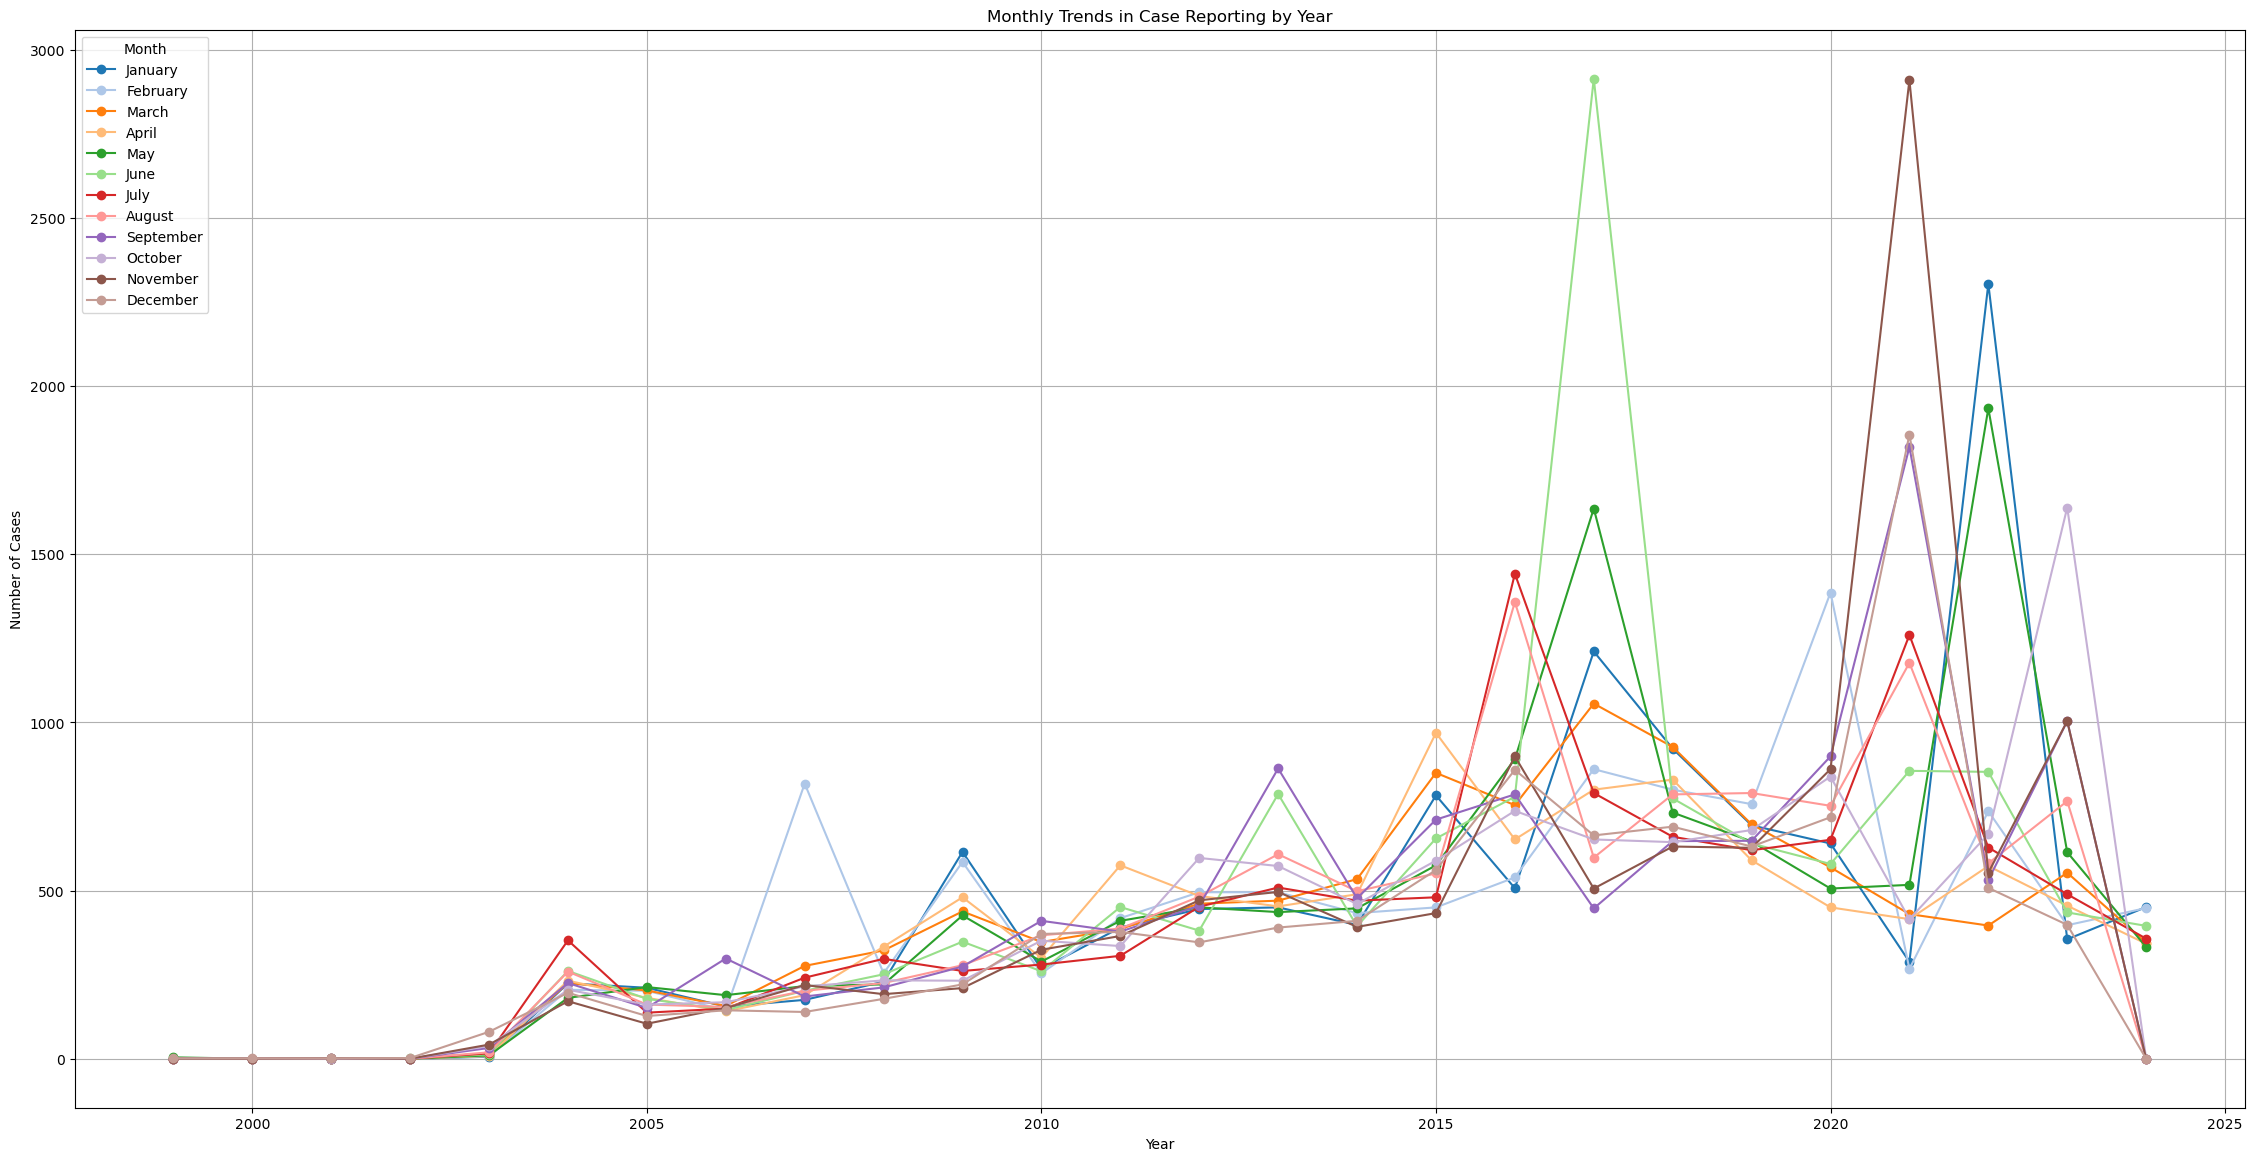

In [40]:
# c. Are there spikes or declines in reporting over time? - Lets see the above data with line chart for each year to see if there is any spike or decline in trend
import matplotlib.pyplot as plt

# Exclude the 'Total_Cases_Year' column from the plot
pivot_df_year_month_T = pivot_df_year_month.drop(columns='Total_Cases_Year')

# Get a colormap with at least 12 distinct colors
colors = plt.get_cmap('tab20').colors[:12]  # Use the first 12 colors

# Plot each month with its own color
ax = pivot_df_year_month_T.plot(
    figsize=(28, 14),
    marker='o',
    color=colors)
plt.title("Monthly Trends in Case Reporting by Year")
plt.xlabel("Year")
plt.ylabel("Number of Cases")
plt.legend(title="Month", loc='upper left')
plt.grid(True)
plt.show()


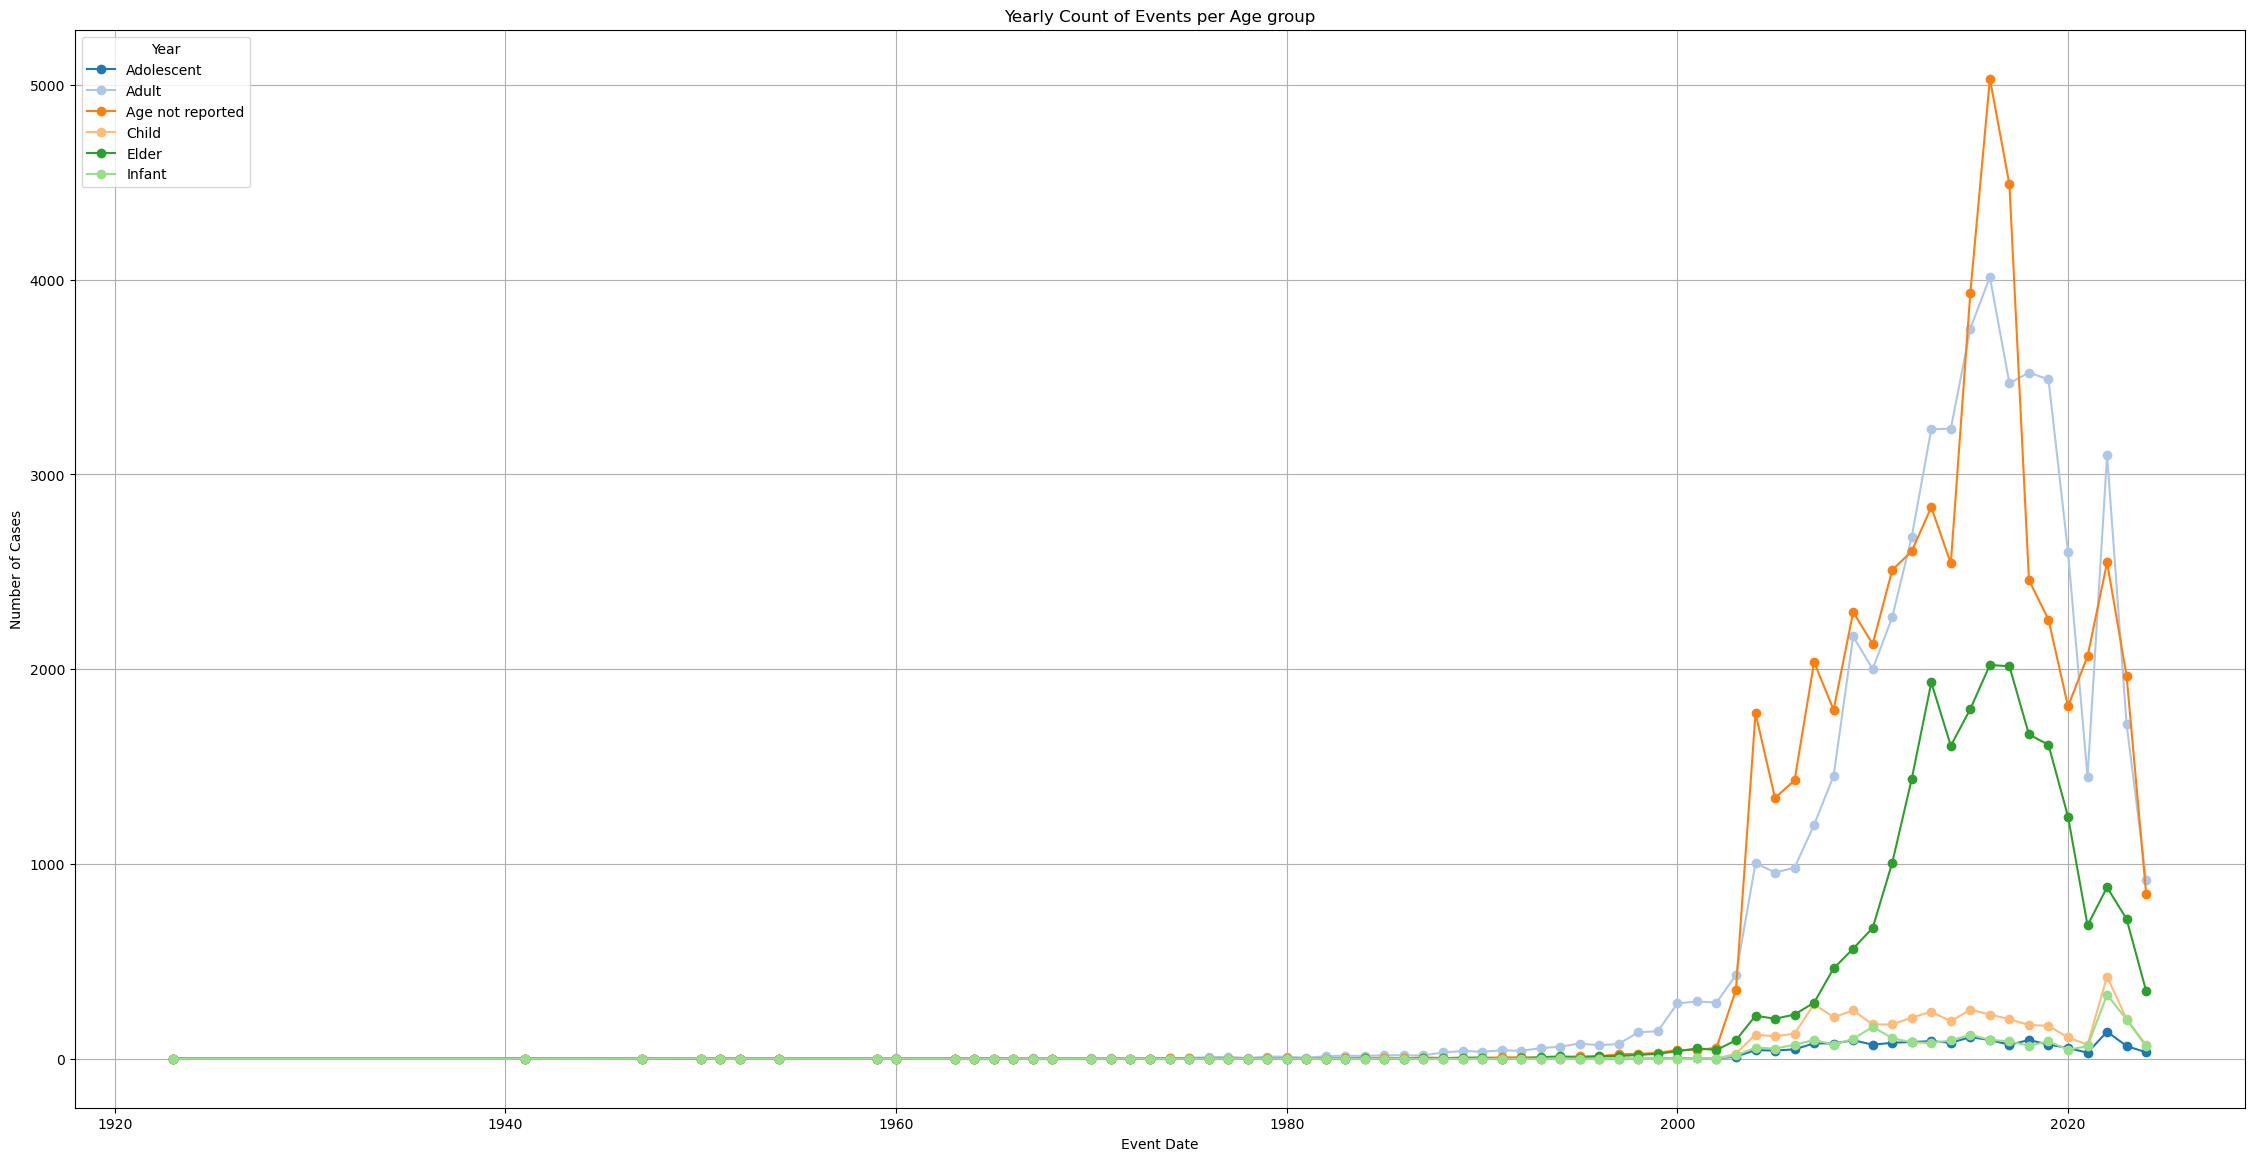

In [41]:
# d. What are the count of events (yearly basis) for each Age group?
# For this we can use Pivot table showing indexes as Years and columns will show Age groups.
# Since we want products we can use df_unique_patients table (to avoid duplicate patient entries. Each row will have one unique patient, Date of Event and list of Case_MedDRA
# We can see the brief overview using df_unique_patients.sample(5)

# There are multiple Date_Event NaN values which needs to be replaced with Date_FDA_First_received and for list of Case_MedDRA we can replace it with just the counts of Events.
df_yearly_events= df_unique_patients[['DATE_EVENT','AGE_GROUP','DATE_FDA_FIRST_RECEIVED_REPORT', 'CASE_MEDDRA_PREFERRED_TERMS']].copy()
df_yearly_events['DATE_EVENT'] = df_yearly_events['DATE_EVENT'].fillna(df_yearly_events['DATE_FDA_FIRST_RECEIVED_REPORT'])
# COPY used to avoid warning from Pandas

# Now we need to extract Year from Date of event to see when patient might have started experiencing the event.
df_yearly_events['DATE_EVENT'] = df_yearly_events['DATE_EVENT'].dt.year

# Counting for number of events in each patient and then summing the total by groups.
df_yearly_events['CASE_MEDDRA_PREFERRED_TERMS_count'] = df_yearly_events['CASE_MEDDRA_PREFERRED_TERMS'].apply(lambda x: len(x))
df_yearly_events = df_yearly_events.groupby(['DATE_EVENT','AGE_GROUP']).size().reset_index(name='event_counts')

# Pivoting the table with the data set
df_pivot_yearly_events = df_yearly_events.pivot_table (index= 'DATE_EVENT', columns = 'AGE_GROUP', values = 'event_counts', fill_value=0, observed=False)
# For Pivot table remove below matplotlib code and df_pivot_yearly_events
# Since its little hard to read the data its better to visualize the data to understand if there is any trend as per age group using line chart
colors = plt.get_cmap('tab20').colors[:6]  # Use the first 12 colors

# Plot each month with its own color
ax = df_pivot_yearly_events.plot(
    figsize=(28, 14),
    marker='o',
    color=colors)
plt.title("Yearly Count of Events per Age group")
plt.xlabel("Event Date")
plt.ylabel("Number of Cases")
plt.legend(title="Year", loc='upper left')
plt.grid(True)
plt.show()

---
# V. Advanced Analysis	
---
    a. Are there patterns or correlations between patient characteristics and outcomes?
    b. Can we predict severe outcomes based on available data?
    c. Hypothesis testing.
    d. Check for distribution of multiple variables histogram.

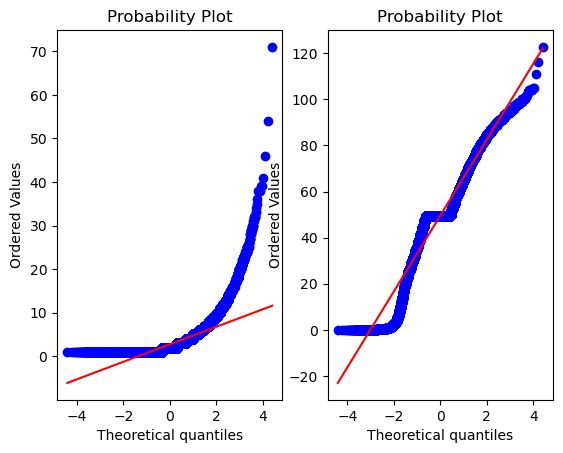

Spearman correlation: -0.050, p-value: 2.127e-75


In [42]:
# a. Are there patterns or correlations between patient characteristics and events?
# Prerequisites for correlational analysis: 2 variables must be continuous in nature. We will check the linearity of both the variables
# a.1. Age_Group vs number of event (Changed from Patient Age Vs number of events due to multiple missing values)
# a.2. Number of suspect drugs Vs number of events

# a.1. Correlational Analysis for Patient Age Vs number of events (Changed to Age_Group vs number of event)
# What we need is AGE_UNIT_IN_YEARS and CASE_MEDDRA_PREFERRED_TERMS_count. We need to create a new dataset that will extract Patient Age and have number of events. 
# When we extract df_unique_patients['AGE_UNIT_IN_YEARS'] there are significant Nan values (more than 38%). Use these codes to see difference in Nan and all value df_unique_patients['AGE_UNIT_IN_YEARS'].isna().sum() and df_unique_patients['REPORT_ID'].count().
# Since missing values are more we cannot go with deletion method, also doing regular imputation method like replacing Nan with Mean/Mode/Median can lead to significant bias.
# Hence we will try to use Multiple imputation method to fill missing values appropriately without biasing the data.
df_norm_test = df_unique_patients.copy()
df_norm_test = df_norm_test[['REPORT_ID','AGE_UNIT_IN_YEARS','CASE_MEDDRA_PREFERRED_TERMS']]
df_norm_test['CASE_MEDDRA_PREFERRED_TERMS_count'] = df_norm_test['CASE_MEDDRA_PREFERRED_TERMS'].apply(lambda x: len(x))
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
imp = IterativeImputer(random_state=0)
df_norm_test['AGE_UNIT_IN_YEARS_imp'] = imp.fit_transform(df_norm_test[['AGE_UNIT_IN_YEARS']])
# Since imputation is performed we need to see if count data is normally distributed, to determine which method of correlation could be used. We will do this with QQ plot for visual representation but statistical test Shapiro-Wilk test for normalization is not performed since sample size large and often it tends to give high p value.
# Lets get the count of the event and check the normality of the count data
# Already imported - matplotlib.pyplot as plt
import scipy.stats as stats
fig, ax = plt.subplots(1, 2)
stats.probplot(df_norm_test['CASE_MEDDRA_PREFERRED_TERMS_count'], dist="norm", plot=ax[0])
stats.probplot(df_norm_test['AGE_UNIT_IN_YEARS_imp'], dist="norm", plot=ax[1])
plt.show()

# Considering the data doesnt follow the normality, we can use non-parametric correlation test (Spearman test)
corr, pval = stats.spearmanr(
    df_norm_test['AGE_UNIT_IN_YEARS_imp'],
    df_norm_test['CASE_MEDDRA_PREFERRED_TERMS_count'])
print(f"Spearman correlation: {corr:.3f}, p-value: {pval:.4g}")
# Ho: There is monotonic relation between Age and no. of events. Ha: There is no monotonic relation between Age and no. of events.
# Result Spearman correlation: -0.050, p-value: 2.127e-75, proves a weak negative correlation between the parameters i.e. if Age increases then number of event tend to decrease. Also p value is extremely small showing the result is statistical significant.
# Ho is rejected suggesting there is no monotonic relation between Age and no. of events. 
# Final impression: correlation is statistically different but the effect size is so small that age and event count do not have a meaningful monotonic relationship.

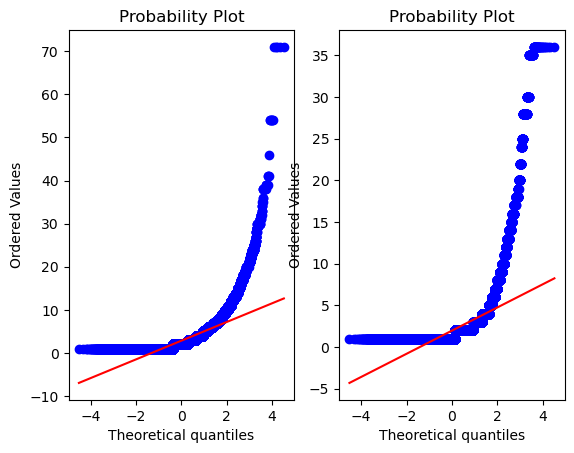

Spearman correlation: -0.136, p-value: 0


In [43]:
# a.2. Number of suspect drugs Vs number of events
# We first need to see for a particular report_ID, count of Suspects were there and then we count the number of events.
sus_v_eve = df[['REPORT_ID','PRODUCT_TYPE', 'CASE_MEDDRA_PREFERRED_TERMS']].copy()
sus_v_eve ['CASE_MEDDRA_PREFERRED_TERMS'] = sus_v_eve ['CASE_MEDDRA_PREFERRED_TERMS'].apply(lambda x: len(x))
# The above code will help us get number of events per patient.
# Now we need to count Suspects first (differentiate from concomitants). Once the counting is done we have to count the number of suspects grouped by report_id.
sus_v_eve['PRODUCT_TYPE'] = sus_v_eve['PRODUCT_TYPE'].apply(lambda x: 1 if x == 'SUSPECT' else 0)
grp_sum = sus_v_eve.groupby(['REPORT_ID'])['PRODUCT_TYPE'].sum()
# Will have to use join method since grouping and sum method, incorrectly adds number of events. e.g Report_id X1 has 3 suspects intotal. As per above code each row will show SUSPECT as 1 and then total no of events (e.g 2 events) repeated across all rows. 
# When group and sum method is performed count of suspect is correctly shown as 3 but no of event is added for all row as well which gives 6. Hence a join method is used.
sus_v_eve = sus_v_eve.merge(grp_sum, on='REPORT_ID', how='left')
# Renaming and droping the helper columns
sus_v_eve.rename(columns = {'CASE_MEDDRA_PREFERRED_TERMS': 'EVENT_COUNT', 'PRODUCT_TYPE_y': 'SUSPECT_COUNT'}, inplace=True)
sus_v_eve.drop('PRODUCT_TYPE_x',axis = 1,inplace=True)
# Use sus_v_eve.sample(10) to see a sample data.
# Checking the normality of both variables to determine which correlation method will we use.
fig, ax = plt.subplots(1, 2)
stats.probplot(sus_v_eve['EVENT_COUNT'], dist="norm", plot=ax[0])
stats.probplot(sus_v_eve['SUSPECT_COUNT'], dist="norm", plot=ax[1])
plt.show()  
# The result shows that data for either variables are not normally distributed so again we have to use spearman coefficient
corr, pval = stats.spearmanr(
    sus_v_eve['SUSPECT_COUNT'],
    sus_v_eve['EVENT_COUNT'])
print(f"Spearman correlation: {corr:.3f}, p-value: {pval:.4g}")
# Ho: There is monotonic relation between no. of suspects and no. of events. Ha: There is no monotonic relation between no. of suspects and no. of events.
# Result Spearman correlation: -0.136, p-value: 0. This proves that null hypothesis Ho is rejected and there is no monotonic relation between no. of suspects and no. of events.
# -0.136 shows very weak but statistically significant negative association between the no. of suspects and no. of event i.e. increase in no. of suspects tends to sligthly decrease no of events.

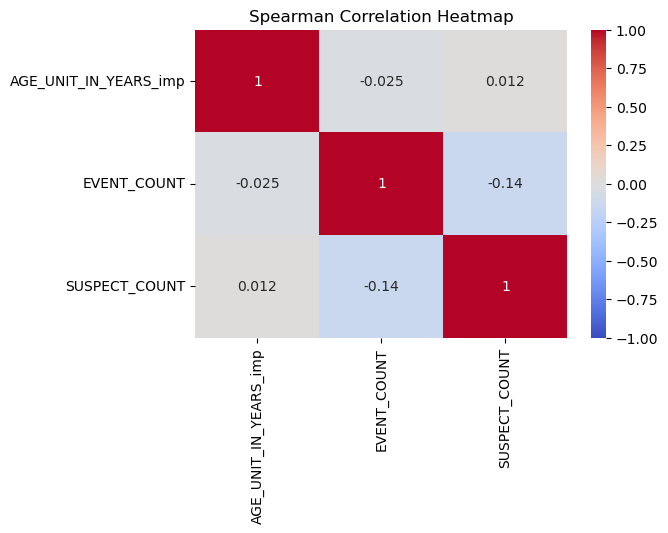

In [44]:
# Lets get all this correlational variables on a heat map , just we would require to understand different correlations between any of these variables. (Its a repition of above process but all in one chart.)
import seaborn as sns
# Select or create relevant variables (we need to merge 2 data)
df_merged = df_norm_test[['REPORT_ID','AGE_UNIT_IN_YEARS_imp', 'CASE_MEDDRA_PREFERRED_TERMS_count']].merge(sus_v_eve, on='REPORT_ID', how='left')
df_merged.drop(['REPORT_ID','CASE_MEDDRA_PREFERRED_TERMS_count'], axis=1,inplace = True)
# Dropping CASE_MEDDRA_PREFERRED_TERMS_count since its same as Event count and Report_ID is not needed in heatmap
# Compute Spearman correlation matrix for selected variables
corr_matrix, p_matrix = stats.spearmanr(df_merged, axis=0)

# Convert to DataFrame with proper labels
corr_df = pd.DataFrame(corr_matrix, index=df_merged.columns, columns=df_merged.columns)
# corr_df.sample(3)..just to see if the table is replicated correctly, which can be used for heatmap
# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman Correlation Heatmap")
plt.show()

In [45]:
 # b. Can we predict severe outcomes based on available data?
# We can try and predict the probability of case having outcomes of death, life-threatening and hospitalization based on sex, age involved per report

# Flag serious outcomes across all rows with 
df1=df_unique_patients.copy()
outcome_flagged = ['death','life threatening','hospitalization','disability','congenital anomaly', 'other serious or important medical event', 'other serious outcome']
df1['SERIOUS_FLAG'] = df1['CASE_OUTCOME'].apply(lambda x: int(any(outcome in (o.strip().lower() for o in x) for outcome in outcome_flagged)))

# Aggregate by REPORT_ID
#cases_by_report = df1.groupby('REPORT_ID').agg(    SERIOUS_CASE=('SERIOUS_FLAG', 'first'),      PRODUCTS=('PRODUCT', lambda x: list(set(x))),  # Unique product list per report    AGE=('AGE_UNIT_IN_YEARS', 'first'),  # Assuming age constant per report    SEX=('SEX', 'first'),  # Assuming sex constant per report
 #   ADE = ('CASE_OUTCOME', 'first')
#).reset_index()

# Impute Age with Multiple imputation
imp = IterativeImputer(random_state=0)
df1['AGE_UNIT_IN_YEARS_imp'] = imp.fit_transform(df_norm_test[['AGE_UNIT_IN_YEARS']])
df1[['AGE_UNIT_IN_YEARS','AGE_UNIT_IN_YEARS_imp']].sample(20)

# Imputing Sex and Encoding Gender as numeric
import numpy as np 
# .fillna () not replacing all values df1['SEX'].value_counts() to see what other values are used.
# any Unknown, Not reported or Unspecified or Nan values will be replaced by 2.
df1['SEX'] = df1['SEX'].map({'Male': 0, 'Female':1, 'Unknown': 2, np.nan:2, 'Not Reported': 2, 'Unspecified (or another gender identity)':2 }) 
df1[['SEX','SERIOUS_FLAG', 'AGE_UNIT_IN_YEARS_imp']].dtypes

# Defining the features (X) (Sex and Age) and Target (Y) (Serious_Flag)
X = df1[['AGE_UNIT_IN_YEARS_imp', 'SEX']]
y = df1['SERIOUS_FLAG']

# Splitting the data to evaluate data reliability
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression Model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# Predicting 
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of serious case

from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.35      0.46      0.40      7146
           1       0.78      0.69      0.73     19378

    accuracy                           0.63     26524
   macro avg       0.56      0.57      0.56     26524
weighted avg       0.66      0.63      0.64     26524

ROC AUC Score: 0.6331919982661443


# Findings from the Model

## The model achieves 63% overall accuracy.

    a. For serious cases (Class 1):
        Precision = 0.78 → When the model predicts a case is serious, it is correct about 78% of the time.
        Recall = 0.69 → It correctly identifies about 69% of all actual serious cases.
        F1-score = 0.73 → Balanced performance, showing the model is fairly effective in detecting serious cases.

    b. For not serious cases (Class 0):
        Precision = 0.35 → Predictions for not serious are often incorrect.
        Recall = 0.46 → Less than half of true not serious cases are identified.
        F1-score = 0.40 → Indicates weak ability to detect not serious outcomes.

## ROC AUC Score = 0.63 → The model has modest discriminative ability, only somewhat better than random guessing (0.5).

    a. Strengths
        The model prioritizes serious case detection, which is clinically important.
        A recall of 69% for serious cases means it captures most patients at risk.
        Predictions for serious outcomes are relatively trustworthy (precision 78%).
    b. Limitations
        Poor detection of not serious cases → Many false alarms, as the model tends to over-predict seriousness.
        Moderate ROC AUC → Indicates the model struggles to reliably separate serious vs. not serious cases.
        Limited feature space (likely only age & sex used) → These alone are not sufficient to capture the complexity of healthcare outcomes.
        Logistic regression simplicity → May not capture non-linear or interaction effects present in real-world data.

In [46]:
# c. Hypothesis testing: 
# c.1 A/B Hypothesis testing: Do Supplementary/Vitamin users experience more serious outcomes compared to other class of products?
#   Test used would be Chi-square test since both the Variables used are categorical in nature with both haveing 2 groups (2 x 2)
#    1. Independent variables (Group A - Vit A (from Description), Group B - all other classes) 
#    2. Dependent variable - unique cases with serious flag (based on severe outcome) vs cases not flagged with severe outcome.
# Hypotheses: H₀: Seriousness outcomes is the same between supplement and all other product users.
#             H₁: Outcome Supplement users have a higher proportion of serious outcomes.

# We can use df1 dataframe from previous cell, since it has unique patient cases marked with serious flags. For chi-square we will use it from scipy.state (imported as stats before)
from scipy.stats import chi2_contingency
df1['PRODUCT_GROUP']= df1['DESCRIPTION'].apply(lambda x: "Supplementary/Vitamin" if "Vit/Min" in x else 'Other') # Checks if Vit/min is reported in Product description then in PRODUCT_GROUP column it will mention "Supplementary/Vitamin" else it will mention "Other"

contingency = pd.crosstab(df1['PRODUCT_GROUP'], df1['SERIOUS_FLAG']) # creates 2x2 contingency table

chi2, p, dof, expected = chi2_contingency(contingency) # Calculates Chi-square test of independence

print('Chi‑Square Statistic:', chi2)
print('Degrees of Freedom:', dof)
print('p‑value:', p)
print('\nContingency Table:\n', contingency)
# Chi‑Square Statistic: 11071.016375156762
# Degrees of Freedom: 1
# p‑value: 0.0 The p‑value ≈ 0 indicates a very strong, highly significant relationship: Supplement/Vitamin users experience significantly more serious outcomes than other product users
# (A) The Chi‑Square test of independence (χ² = 11 071.02, df = 1, p < 0.001) revealed a statistically significant association between product category and outcome seriousness. 
# (B) Supplement/Vitamin products exhibited a higher proportion of serious reports (≈ 91%) compared to other products (≈ 64%). 
# Therefore, we reject the null hypothesis (as per A) and conclude that supplement/vitamin users are more likely to report serious adverse outcomes (as per B).

Chi‑Square Statistic: 11071.016375156762
Degrees of Freedom: 1
p‑value: 0.0

Contingency Table:
 SERIOUS_FLAG               0      1
PRODUCT_GROUP                      
Other                  31927  56905
Supplementary/Vitamin   3801  39983


In [47]:
# c.2 A/B Hypothesis testing: Across all different age groups, does the average number of symptoms differ?
# Test used would be ANOVA one-way test since Age_group (Categorical innature with multiple groups) is tested against Number of symptoms per age group (Numerical in nature).
#    1. Independent variables (AGE_GROUP categorical)
#    2. Dependent variable (calculating mean number of symptoms per age group.
# Hypotheses: H₀: The mean number of symptoms (num_symptoms) is the same across all age groups.
#             H₁: At least one age group differs significantly in the mean number of symptoms reported.

# We can use df1 dataframe again, since it has unique patients. We need a new column that counts number of symptoms per unique case
from scipy.stats import f_oneway

df1['num_symptoms'] = df1['CASE_MEDDRA_PREFERRED_TERMS'].apply(lambda x: len (x)) # Since all symptoms are in list format, len function was used.

# Preparing groups (One consideration is that Age not reported will not be counted. This will reduce the sample size but will reflect meaningful insight for different age groups)
valid_age_groups = ['Infant', 'Child', 'Adolescent', 'Adult', 'Elder']

filtered = df1[df1['AGE_GROUP'].isin(valid_age_groups)].copy() #Filtering the Age groups that are considered valid

# Then prepare groups
groups = [group['num_symptoms'] for _, group in filtered.groupby('AGE_GROUP')] # this will group all the cases as per Age_group.
# Use this whole code to see how its the numbers are seen for every case, grouped by age_group  ""  for name, group in filtered.groupby('AGE_GROUP'):  print(name)  print(group['num_symptoms'].head())  "" 

f_stat, p_val = f_oneway(*groups)
print('F-statistic:', f_stat)
print('p-value:', p_val)
# F-statistic: 59.99698931605994 : This shows that variation within different age-groups means is much larger than variation within age-group means
# p-value: 1.1106624785948572e-50 : p value is very very low (near zero), hence we reject the null hypothesis i.e. Mean number of symptoms is not same for all age groups.

# Below Post‑hoc contrasts (Tukey HSD) will identify which specific age groups’ mean symptom counts differ significantly.
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=filtered['num_symptoms'],
                          groups=filtered['AGE_GROUP'],
                          alpha=0.05)
print(tukey)
# Tukey’s HSD test confirms that Elders tend to report the most symptoms and Adolescents the fewest, while Adults, Children, and Infants show broadly similar averages.

F-statistic: 59.99698931605994
p-value: 1.1106624785948572e-50
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1   group2 meandiff p-adj   lower   upper  reject
--------------------------------------------------------
Adolescent  Adult  -0.3832    0.0 -0.5653 -0.2011   True
Adolescent  Child  -0.3261 0.0003 -0.5378 -0.1143   True
Adolescent  Elder  -0.6617    0.0 -0.8474  -0.476   True
Adolescent Infant  -0.2906  0.007 -0.5267 -0.0545   True
     Adult  Child   0.0572 0.6702 -0.0598  0.1741  False
     Adult  Elder  -0.2785    0.0 -0.3362 -0.2208   True
     Adult Infant   0.0926 0.4904 -0.0642  0.2494  False
     Child  Elder  -0.3356    0.0 -0.4581 -0.2131   True
     Child Infant   0.0354 0.9867  -0.155  0.2259  False
     Elder Infant   0.3711    0.0  0.2101  0.5321   True
--------------------------------------------------------


In [48]:
# c.3 A/B Hypothesis testing: Do cases flagged as serious differ in the number of symptoms reported compared to non‑serious cases?
# Test used would be Independent Samples t‑Test since serious flag (either marked as 0 or 1) (Categorical innature with only 2 groups) is tested against Number of symptoms per age group (Numerical in nature).
#    1. Independent variables (Serious Flag categorical)
#    2. Dependent variable (calculating mean number of symptoms per age group.
# Hypotheses: H₀: The mean number of symptoms is the same between Serious and Non‑Serious cases
#             H₁: The mean number of symptoms differs between the two groups.

# We need to create 2 subsets where it has cases that are flagged as serious and number of symptoms for each case 
serious_flag_cases = df1.loc[df1['SERIOUS_FLAG'] == 1, 'num_symptoms']
not_serious_flag_cases = df1.loc[df1['SERIOUS_FLAG'] == 0, 'num_symptoms']

# lets run the independent t-test
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(serious_flag_cases, not_serious_flag_cases, equal_var=False)

print("T‑Statistic:", t_stat)
print("p‑value:", p_val)
print("Mean (Serious Flagged):", serious_flag_cases.mean())
print("Mean (Not Serious Flagged):", not_serious_flag_cases.mean())
# T‑Statistic: -25.139443521077045 : 25 shows that difference between two means is larger than random within group variation.
# p‑value: 7.650186659725875e-139 : Very low hence suggesting that there is significant difference between serious and non‑serious cases in terms of the average number of symptoms reported.
# Mean (Serious Flagged): 2.6423396086202624
# Mean (Not Serious Flagged): 2.9991603224361847

T‑Statistic: -25.139443521077045
p‑value: 7.650186659725875e-139
Mean (Serious Flagged): 2.6423396086202624
Mean (Not Serious Flagged): 2.9991603224361847


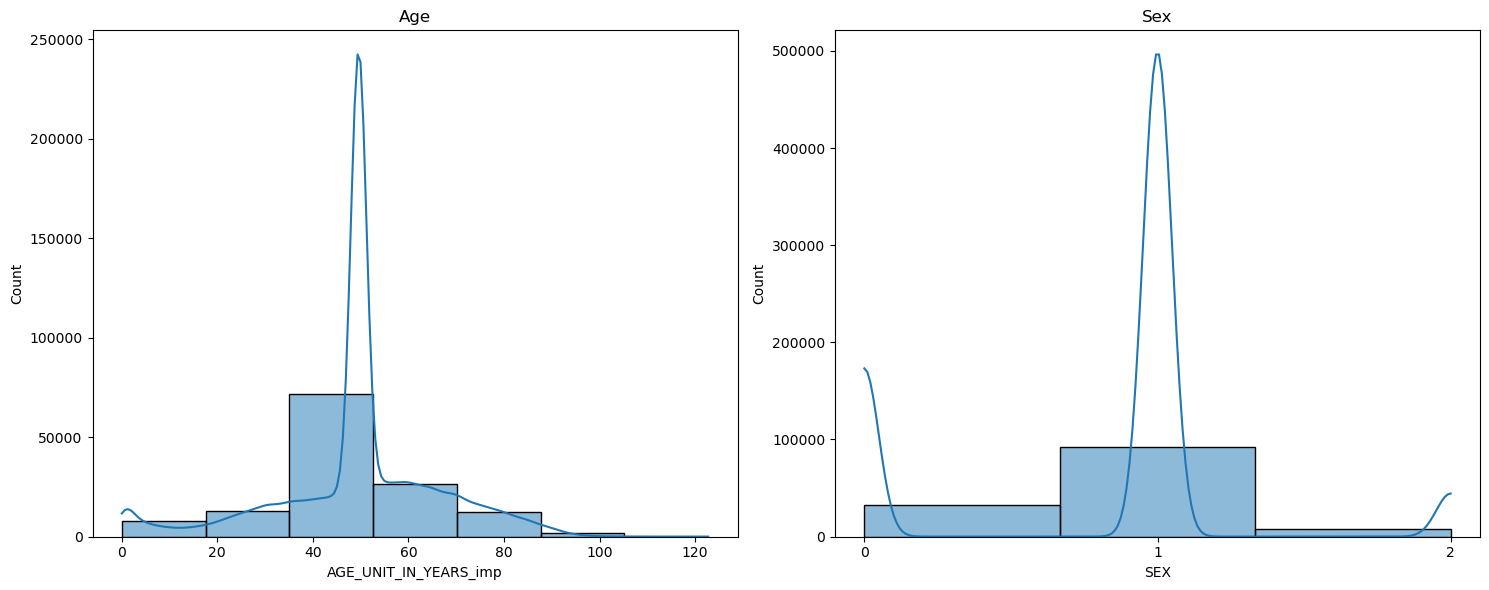

In [49]:
# d. Check for distribution of multiple variables histogram

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('Age')
sns.histplot(df1['AGE_UNIT_IN_YEARS_imp'], bins = 7, edgecolor = 'k', kde= True)

plt.subplot(1,2,2)
plt.title('Sex')
ax = sns.histplot(df1['SEX'], bins=3, edgecolor='k', kde=True)
ticks = [0, 1, 2]
ax.set_xticks(ticks)
plt.tight_layout()
plt.show()